## Analisis Data Segmentasi Nasabah Bank

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### Exploratory Data Analysis (EDA)

#### Inspeksi Awal Data

In [2]:
df = pd.read_csv('bank_transactions.csv')
df = df.sample(frac=0.02, random_state=42)

df.info()
print(df.describe())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 20971 entries, 892845 to 108465
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            20971 non-null  object 
 1   CustomerID               20971 non-null  object 
 2   CustomerDOB              20903 non-null  object 
 3   CustGender               20948 non-null  object 
 4   CustLocation             20970 non-null  object 
 5   CustAccountBalance       20920 non-null  float64
 6   TransactionDate          20971 non-null  object 
 7   TransactionTime          20971 non-null  int64  
 8   TransactionAmount (INR)  20971 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 1.6+ MB
       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        2.092000e+04     20971.000000             20971.000000
mean         1.026804e+05    157102.286062              1584.136848
std          4.246671e+05     5

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
892845,T892846,C5725279,8/9/84,M,JASPUR,84447.82,7/9/16,183210,11858.00
444994,T444995,C4588538,2/1/94,M,GURGAON,12549.49,16/8/16,161300,250.00
614896,T614897,C2416476,14/11/90,M,NEW DELHI,33607.65,26/8/16,102007,3360.00
457036,T457037,C5940151,15/9/90,M,HYDERABAD,38238.86,21/8/16,110438,250.00
997441,T997442,C5922989,27/11/88,M,PURBO MEDINIPUR,9506.85,14/9/16,90810,33.00
518219,T518220,C8296884,31/10/89,M,BANGALORE,635863.63,19/8/16,215646,2688.00
778232,T778233,C6671851,1/1/1800,M,SHOPPING COMPLEX THIRUVANATHAPURAM,5867.38,6/9/16,193036,870.00
151835,T151836,C8927812,3/3/87,M,NEW DELHI,63911.56,4/8/16,30857,499.00
446575,T446576,C7511745,23/3/92,F,GURGAON,19853.15,16/8/16,183906,280.00
887527,T887528,C6126877,1/10/93,M,GURGAON,3848.86,7/9/16,201500,203.45


 #### Penanganan Missing Values dan Cek Outlier

Sebelum Penanganan Missing Values: 
TransactionID               0
CustomerID                  0
CustomerDOB                68
CustGender                 23
CustLocation                1
CustAccountBalance         51
TransactionDate             0
TransactionTime             0
TransactionAmount (INR)     0
dtype: int64
Setelah Penanganan Missing Values: 
TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64


<Axes: >

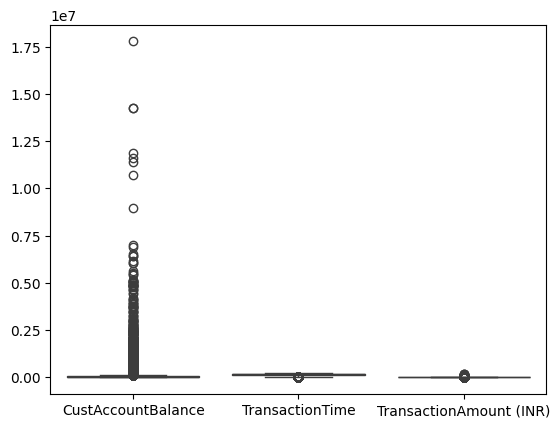

In [3]:

print("Sebelum Penanganan Missing Values: ")
print(df.isnull().sum())

print("Setelah Penanganan Missing Values: ")
df = df.dropna()
print(df.isnull().sum())

import seaborn as sns
sns.boxplot(df)

### Analisis Univariat

<Figure size 1200x500 with 0 Axes>

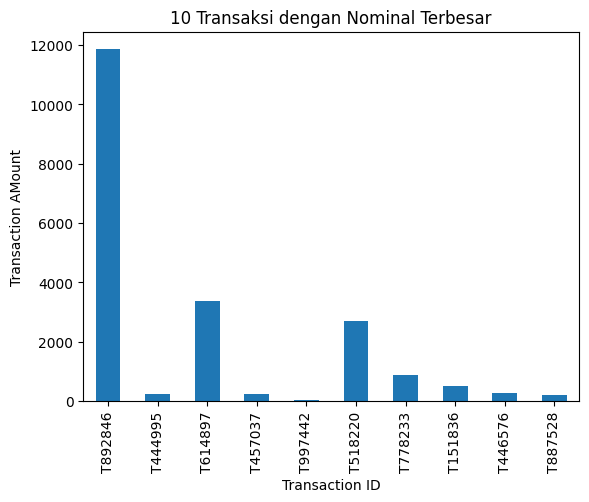

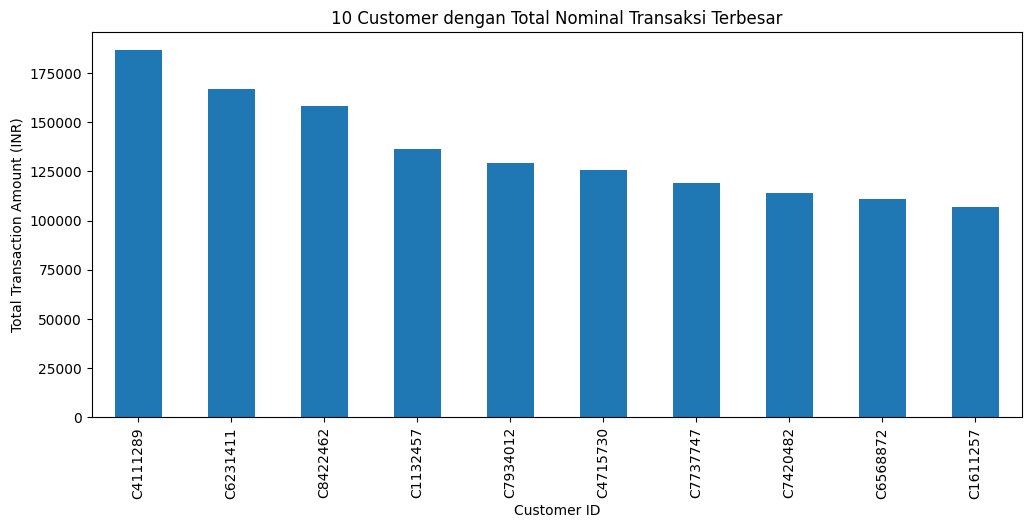

In [4]:
plt.figure(figsize=(12,5))
df.head(10).plot(
    x="TransactionID",
    y="TransactionAmount (INR)",
    kind='bar',
    legend=False
)
plt.title('10 Transaksi dengan Nominal Terbesar')
plt.xlabel('Transaction ID')
plt.ylabel('Transaction AMount')
plt.show()

customer_sum = df.groupby('CustomerID')['TransactionAmount (INR)'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,5))
customer_sum.plot(kind='bar')

plt.title('10 Customer dengan Total Nominal Transaksi Terbesar')
plt.xlabel('Customer ID')
plt.ylabel('Total Transaction Amount (INR)')
plt.show()

### Data Processing

In [5]:
df_agg = df.groupby('CustomerID').agg(
    Jumlah_Transaksi=('TransactionID', 'count'),
    Total_Amount=('TransactionAmount (INR)', 'sum'),
    Avg_Amount=('TransactionAmount (INR)', 'mean'),
    Max_Amount=('TransactionAmount (INR)', 'max'),
    Mean_AccountBalance=('CustAccountBalance', 'mean'),
    CustGender=('CustGender', 'first'),
    CustLocation=('CustLocation', 'first'),
    CustomerDOB=('CustomerDOB', 'first')
).reset_index()


#### Standarisasi Fitur Numerik

In [6]:
# Konversi Date of Birth (DOB) ke Umur
df_agg['CustomerDOB'] = pd.to_datetime(df_agg['CustomerDOB'], format='%d/%m/%y', errors='coerce')
# print(df['CustomerDOB'].dt.year.value_counts().sort_index())
df_agg.loc[df_agg['CustomerDOB'].dt.year > 2025, 'CustomerDOB'] = df_agg['CustomerDOB'] - pd.DateOffset(years=100)
df_agg['CustomerDOB'].head(10)
today = pd.Timestamp.now()
df_agg['Umur'] = (today - df_agg['CustomerDOB']).dt.days // 365
df_agg = df_agg.dropna()
print(df_agg['Umur'].isna().sum())
df_agg['Umur'] = df_agg['Umur'].astype(int)
print(df_agg[['CustomerID','Umur']].head(10))
# df_agg.drop(df_agg['CustomerDOB'])

# Konversi Gender Male dan Female ke 0 dan 1
df_agg['CustGender'] = df_agg['CustGender'].map({'M': 1, 'F': 0})
df_agg.head(10)


0
   CustomerID  Umur
0    C1010024    60
1    C1010243    45
2    C1010279    38
3    C1010517    30
4    C1010655    34
5    C1010666    42
6    C1010828    39
8    C1010923    39
9    C1011343    38
10   C1011678    43


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur
0,C1010024,1,5000.0,5000.0,5000.0,87058.65,1,KOLKATA,1965-06-21,60
1,C1010243,2,929.0,464.5,676.0,98513.39,1,TEHRI GARHWAL,1980-03-01,45
2,C1010279,1,368.0,368.0,368.0,137.91,0,ANDHERI WEST MUMBAI,1987-01-11,38
3,C1010517,1,150.0,150.0,150.0,14750.09,1,SRIPERUMBUDUR,1994-10-19,30
4,C1010655,1,712.0,712.0,712.0,45856.24,1,MEERUT,1991-08-06,34
5,C1010666,1,497.0,497.0,497.0,4450.94,1,NANDURBAR,1983-06-06,42
6,C1010828,1,63.0,63.0,63.0,11719.95,1,MUMBAI,1986-10-05,39
8,C1010923,1,117.0,117.0,117.0,16748.07,0,BANGALORE,1986-04-11,39
9,C1011343,1,420.0,420.0,420.0,347090.85,1,NEW DELHI,1987-01-23,38
10,C1011678,1,270.0,270.0,270.0,13742.77,1,KOLKATA,1982-06-07,43


#### Scaling Data

In [7]:

# Scaling Data
num_cols = ['Jumlah_Transaksi','Total_Amount','Avg_Amount',
            'Max_Amount','Mean_AccountBalance','CustGender',
            'Umur']

scaler = StandardScaler()
df_agg[num_cols] = scaler.fit_transform(df_agg[num_cols])
df_agg.head(10)


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur
0,C1010024,-0.059823,0.669790,0.672215,0.670385,-0.013519,0.609566,KOLKATA,1965-06-21,2.306762
1,C1010243,16.262648,-0.102351,-0.189681,-0.150049,0.017588,0.609566,TEHRI GARHWAL,1980-03-01,0.587194
2,C1010279,-0.059823,-0.208755,-0.208020,-0.208489,-0.249564,-1.640513,ANDHERI WEST MUMBAI,1987-01-11,-0.215271
3,C1010517,-0.059823,-0.250103,-0.249447,-0.249852,-0.209882,0.609566,SRIPERUMBUDUR,1994-10-19,-1.132373
4,C1010655,-0.059823,-0.143509,-0.142648,-0.143219,-0.125410,0.609566,MEERUT,1991-08-06,-0.673822
5,C1010666,-0.059823,-0.184288,-0.183505,-0.184013,-0.237851,0.609566,NANDURBAR,1983-06-06,0.243281
6,C1010828,-0.059823,-0.266604,-0.265980,-0.266360,-0.218111,0.609566,MUMBAI,1986-10-05,-0.100633
8,C1010923,-0.059823,-0.256362,-0.255718,-0.256114,-0.204457,-1.640513,BANGALORE,1986-04-11,-0.100633
9,C1011343,-0.059823,-0.198893,-0.198138,-0.198623,0.692633,0.609566,NEW DELHI,1987-01-23,-0.215271
10,C1011678,-0.059823,-0.227343,-0.226643,-0.227083,-0.212618,0.609566,KOLKATA,1982-06-07,0.357919


#### Encoding Data Column 'CustLocation'

In [8]:
# Encoding kolom kategorical dari Customer Location
top_locations = df_agg['CustLocation'].value_counts().head(100).index
df_agg['CustLocation_reduced'] = df_agg['CustLocation'].apply(lambda x: x if x in top_locations else 'Other')

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
encoded_sparse = encoder.fit_transform(df_agg[['CustLocation_reduced']])
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_sparse, columns=encoder.get_feature_names_out(['CustLocation_reduced']))
df_agg = pd.concat([df_agg.drop(columns=['CustLocation_reduced']).reset_index(drop=True), encoded_df], axis=1)

df_agg.info()
df_agg.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19645 entries, 0 to 19644
Columns: 111 entries, CustomerID to CustLocation_reduced_ZIRAKPUR
dtypes: Sparse[float64, 0](101), datetime64[ns](1), float64(7), object(2)
memory usage: 1.7+ MB


,CustomerID,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,CustGender,CustLocation,CustomerDOB,Umur,...,CustLocation_reduced_THANE,CustLocation_reduced_THANE WEST,CustLocation_reduced_UDAIPUR,CustLocation_reduced_VADODARA,CustLocation_reduced_VAPI,CustLocation_reduced_VARANASI,CustLocation_reduced_VIJAYAWADA,CustLocation_reduced_VISAKHAPATNAM,CustLocation_reduced_WARANGAL,CustLocation_reduced_ZIRAKPUR
0,C1010024,-0.059823,0.669790,0.672215,0.670385,-0.013519,0.609566,KOLKATA,1965-06-21,2.306762,...,0,0,0,0,0,0,0,0,0,0
1,C1010243,16.262648,-0.102351,-0.189681,-0.150049,0.017588,0.609566,TEHRI GARHWAL,1980-03-01,0.587194,...,0,0,0,0,0,0,0,0,0,0
2,C1010279,-0.059823,-0.208755,-0.208020,-0.208489,-0.249564,-1.640513,ANDHERI WEST MUMBAI,1987-01-11,-0.215271,...,0,0,0,0,0,0,0,0,0,0
3,C1010517,-0.059823,-0.250103,-0.249447,-0.249852,-0.209882,0.609566,SRIPERUMBUDUR,1994-10-19,-1.132373,...,0,0,0,0,0,0,0,0,0,0
4,C1010655,-0.059823,-0.143509,-0.142648,-0.143219,-0.125410,0.609566,MEERUT,1991-08-06,-0.673822,...,0,0,0,0,0,0,0,0,0,0
5,C1010666,-0.059823,-0.184288,-0.183505,-0.184013,-0.237851,0.609566,NANDURBAR,1983-06-06,0.243281,...,0,0,0,0,0,0,0,0,0,0
6,C1010828,-0.059823,-0.266604,-0.265980,-0.266360,-0.218111,0.609566,MUMBAI,1986-10-05,-0.100633,...,0,0,0,0,0,0,0,0,0,0
7,C1010923,-0.059823,-0.256362,-0.255718,-0.256114,-0.204457,-1.640513,BANGALORE,1986-04-11,-0.100633,...,0,0,0,0,0,0,0,0,0,0
8,C1011343,-0.059823,-0.198893,-0.198138,-0.198623,0.692633,0.609566,NEW DELHI,1987-01-23,-0.215271,...,0,0,0,0,0,0,0,0,0,0
9,C1011678,-0.059823,-0.227343,-0.226643,-0.227083,-0.212618,0.609566,KOLKATA,1982-06-07,0.357919,...,0,0,0,0,0,0,0,0,0,0


### KMeans Algorithm

In [9]:
df_num = df_agg.select_dtypes(include='number')
df_num.head(10)

pca = PCA(n_components=50, random_state=42)
df_reduced = pca.fit_transform(df_num)

wcss = []
scores = []

for i in range (2,11):
  k_means = KMeans(n_clusters=i, random_state=42)
  k_means.fit(df_num)

  wcss.append(k_means.inertia_)
  scores.append(silhouette_score(df_num, k_means.labels_))

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: Use

#### WCSS dan Silhoutte

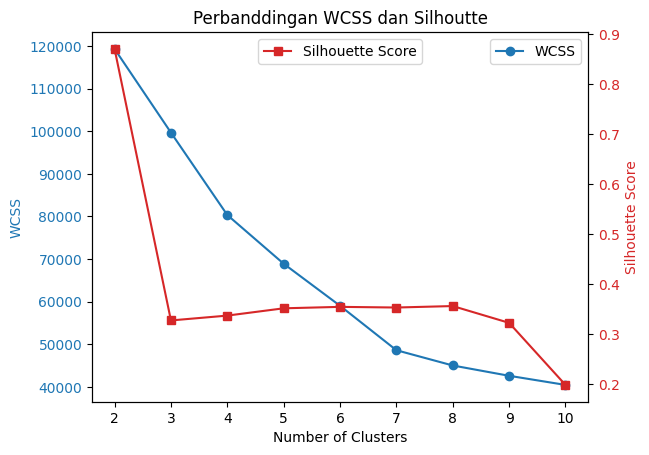

In [10]:
k = range(2,11)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.plot(k, wcss, marker='o', color=color, label="WCSS")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k, scores, marker='s', color=color, label="Silhouette Score")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper center")

plt.title("Perbanddingan WCSS dan Silhoutte")
plt.show()

#### Knee Elbow untuk Menentukan K Optimal

Elbow (optimal k) berdasarkan WCSS: 7


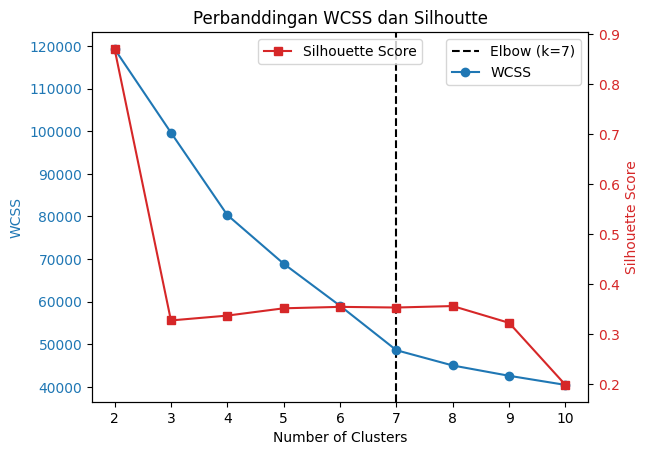

In [11]:
from kneed import KneeLocator

kl = KneeLocator(k, wcss, curve="convex", direction="decreasing")
k_optimal = kl.knee

print("Elbow (optimal k) berdasarkan WCSS:", k_optimal)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS', color=color)
ax1.axvline(k_optimal, color='black', linestyle='--', label=f"Elbow (k={k_optimal})")
ax1.plot(k, wcss, marker='o', color=color, label="WCSS")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="upper right")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k, scores, marker='s', color=color, label="Silhouette Score")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="upper center")

plt.title("Perbanddingan WCSS dan Silhoutte")
plt.show()


#### Hasil KMeans

c:\Users\ASUS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:919: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Rata rata tiap cluster: 



,Jumlah_Transaksi,Total_Amount,Avg_Amount,Max_Amount,Mean_AccountBalance,Umur
cluster,,,,,,
0,-0.059823,-0.122776,-0.121875,-0.122478,-0.111812,-0.316961
1,-0.059823,17.744003,17.779245,17.750974,0.684142,0.914249
2,-0.059823,-0.080120,-0.079137,-0.079805,-0.065380,-0.270567
3,16.492542,0.346413,0.033581,0.251580,0.138113,0.078590
4,-0.059823,0.022302,0.023482,0.022654,0.226044,1.886754
5,-0.059823,0.243927,0.245533,0.244363,11.263487,1.152291
6,-0.059823,4.401667,4.411265,4.403656,0.277458,0.514040


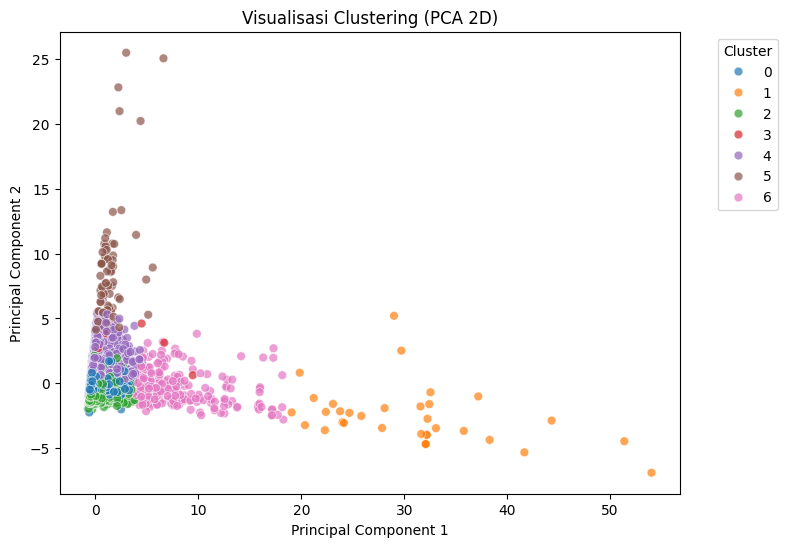

In [12]:
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
labels = kmeans_final.fit_predict(df_reduced)

df_num['cluster'] = kmeans_final.fit_predict(df_num)
cluster_summary = df_num.groupby('cluster').mean()
print("Rata rata tiap cluster: \n")

pd.options.display.float_format = '{:.2f}'.format  
cols_to_show = ['Jumlah_Transaksi', 'Total_Amount', 'Avg_Amount', 'Max_Amount', 'Mean_AccountBalance', 'Umur']
display(cluster_summary[cols_to_show].style.background_gradient(cmap='coolwarm').set_caption('Rata-rata Tiap Cluster'))

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df_reduced[:,0], y=df_reduced[:,1],
    hue=kmeans_final.labels_,
    palette='tab10',
    s=40, alpha=0.7
)
plt.title('Visualisasi Clustering (PCA 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

| Cluster | Ciri Utama                                                                          | Interpretasi                                                                                                                    |
| -------- | ----------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- |
| **0**   | Semua fitur negatif (terutama Umur -0.31, Total_Amount -0.12)                       | Pelanggan **rendah aktivitas dan nilai transaksi kecil**, cenderung **muda atau baru**                                          |
| **1**   | Total_Amount dan Avg_Amount **sangat tinggi (≈ +17.7)**, Umur juga positif (0.9)    | Pelanggan **paling bernilai tinggi**, sering melakukan transaksi besar — **VIP / High spender**                                 |
| **2**   | Semua fitur sedikit di bawah 0 (sekitar -0.07)                                      | Pelanggan **rendah aktivitas tapi stabil**, tidak seaktif cluster lain                                                          |
| **3**   | Jumlah_Transaksi **tinggi (+16.49)** tapi Total_Amount hanya +0.34                  | Pelanggan **sering transaksi kecil**, mungkin **frekuensi tinggi tapi nominal kecil**                                           |
| **4**   | Umur **tinggi (+1.88)**, saldo dan nominal transaksi **sedikit di atas rata-rata**  | Pelanggan **lebih tua, stabil, mungkin pelanggan lama dengan transaksi moderat**                                                |
| **5**   | Mean_AccountBalance **sangat tinggi (+11.26)**, Total_Amount juga di atas rata-rata | Pelanggan dengan **saldo besar di akun**, mungkin **nasabah prioritas / penyimpan besar**                                       |
| **6**   | Semua fitur di atas rata-rata, terutama Total_Amount +4.4, saldo +0.27              | Pelanggan dengan **transaksi dan nilai cukup tinggi**, **menengah ke atas** (high spender tapi tidak ekstrem seperti cluster 1) |
